In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.dates as mdates
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

from matplotlib import pyplot

import joblib
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
os.getcwd()

'c:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS'

In [3]:
# from pathlib import Path
# folder_path = Path("calfews_src/data/MGHMM_synthetic/")
# csv_files = folder_path.glob("DailyQ_s0.csv")

# for csv_file in csv_files:

#     df = pd.read_csv(csv_file)
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     df.set_index('Date', inplace=True)
#     df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
#     df.to_csv(csv_file)

#     print(f"Processed {csv_file}")

In [4]:

# def filter_dates(file_path, output_folder):
#     df = pd.read_csv(file_path)
    
    
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    
#     # Define the original and new date ranges
#     original_start_date = pd.Timestamp('1997-01-01')
#     original_end_date = pd.Timestamp('2000-12-31')
#     new_start_date = pd.Timestamp('2024-01-01')
#     new_end_date = pd.Timestamp('2027-12-31')
   
#     date_shift = new_start_date - original_start_date
 
#     df['Date'] = df['Date'] + date_shift
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['Day'] = df['Date'].dt.day

#     df.drop(columns=['Date'], inplace=True)

#     output_file_path = os.path.join(output_folder, os.path.basename(file_path))
#     df.to_csv(output_file_path, index=False)

# # Define folder paths
# input_folder_path = 'calfews_src/data/MGHMM_synthetic/'
# output_folder_path = 'calfews_src/data/MGHMM_synthetic/'

# # Create output folder if it doesn't exist
# if not os.path.exists(output_folder_path):
#     os.makedirs(output_folder_path)

# # Process all files in the folder
# filenames = [f'DailyQ_s{i}.csv' for i in range(100)]

# for filename in filenames:
#     file_path = os.path.join(input_folder_path, filename)
#     filter_dates(file_path, output_folder_path)

In [5]:
# # cut the synthetic data to water years to run CALFEWS

# def filter_dates(file_path):
#     df = pd.read_csv(file_path)
    
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     start_date = pd.Timestamp('2024-10-01')
#     end_date = pd.Timestamp('2027-9-30')
    
#     filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
#     filtered_df = filtered_df.drop(columns=['Date'])
#         # Drop the last row
#     # if not filtered_df.empty:
#     #     filtered_df = filtered_df.iloc[:-1]
#     filtered_df.to_csv(file_path, index=False)

# folder_path = 'calfews_src/data/MGHMM_synthetic/'
# filenames = [f'DailyQ_s{i}.csv' for i in range(100)]

# for filename in filenames:
#     file_path = os.path.join(folder_path, filename)
#     filter_dates(file_path)

In [6]:
#Load data (NQH2O water price index)
NQH2O_hist = pd.read_excel('calfews_src/data/price_index/NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]

NQH2O_pre = pd.read_csv('calfews_src/data/price_index/AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df.reset_index(drop=True, inplace=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['9_Month_Forward_Avg'] = np.nan

# Function to calculate the 6-month forward average
def calculate_9_month_forward_avg(current_date, df):
    target_date = current_date + pd.DateOffset(months=9)
    window_start = target_date - pd.DateOffset(months=1)
    window_end = target_date + pd.DateOffset(months=1)
    
    # Create a mask to filter rows within the window
    mask = (df['Date'] >= window_start) & (df['Date'] <= window_end)
    
    # Extract the 'NQH2O' prices within the window
    relevant_prices = df.loc[mask, 'NQH2O']
    
    # Calculate and return the average if available
    if len(relevant_prices) > 0:
        return relevant_prices.mean()
    else:
        return None
    # mask = (df['Date'] >= current_date) & (df['Date'] <= end_date)
    # relevant_prices = df.loc[mask, 'NQH2O']

    # if len(relevant_prices) > 0:
    #     return relevant_prices.mean()
    # else:
    #     return None

combined_df['9_Month_Forward_Avg'] = combined_df['Date'].apply(lambda x: calculate_9_month_forward_avg(x, combined_df))
cutoff_date = pd.to_datetime('2024-01-01')
combined_df.loc[combined_df['Date'] > cutoff_date, '9_Month_Forward_Avg'] = np.nan
# combined_df['NQH2O_past3M'] = combined_df['NQH2O'].rolling(window='90D', min_periods=3).mean()
# combined_df['NQH2O_f9_past3M'] = combined_df['9_Month_Forward_Avg'].rolling(window='90D', min_periods=3).mean()
combined_df

,Date,NQH2O,9_Month_Forward_Avg
0,2013-01-09,222.02,282.813333
1,2013-01-16,146.89,283.800000
2,2013-01-23,113.34,285.757778
3,2013-01-30,109.68,288.353333
4,2013-02-06,109.77,291.208889
...,...,...,...
634,2024-09-25,431.69,NaN
635,2024-09-26,431.69,NaN
636,2024-09-27,431.69,NaN
637,2024-09-30,431.69,NaN


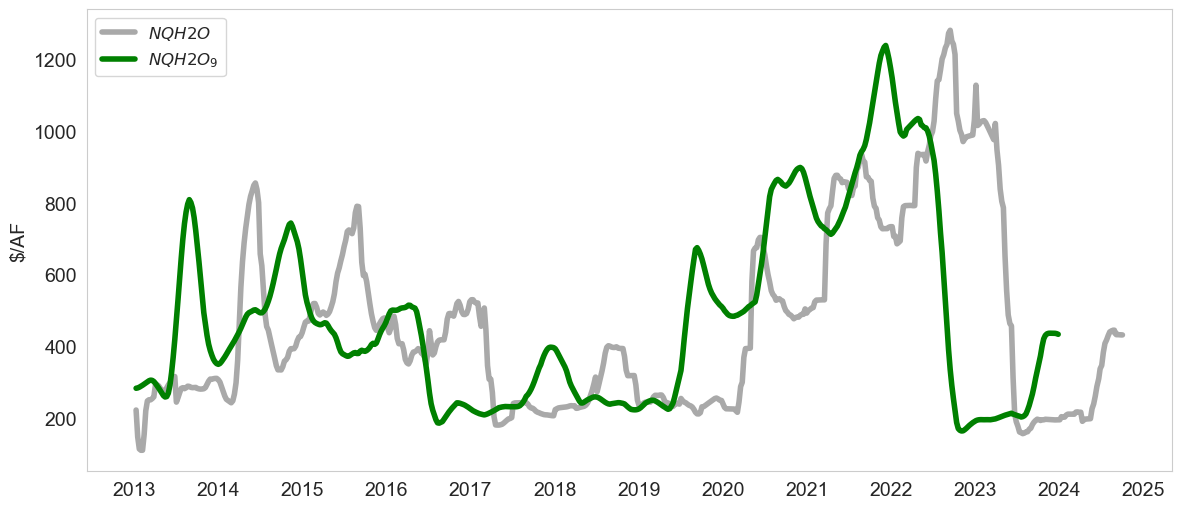

In [7]:

plt.figure(figsize=(14, 6))

plt.plot(combined_df['Date'], combined_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
plt.plot(combined_df['Date'], combined_df['9_Month_Forward_Avg'], label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=4)
plt.ylabel('$/AF', fontsize=14)
# plt.ylim(0, 1400)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(False)

plt.show()

In [8]:
#around 100 columns do not exisit in the synthetic data, remove those features in the validation data that will be used to train the model
reference_file = 'results/1/results.hdf5'
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

reference_df = get_results_sensitivity_number_outside_model(reference_file, '')
datDaily = get_results_sensitivity_number_outside_model(output_file, '')

reference_columns = set(reference_df.columns)
datDaily_columns = set(datDaily.columns)

columns_to_remove = datDaily_columns - reference_columns
datDaily.drop(columns=columns_to_remove, inplace=True)

print(f"Number of columns removed: {len(columns_to_remove)}")
print("Removed columns in datDaily:")
print(columns_to_remove)

Number of columns removed: 492
Removed columns in datDaily:
{'alta_ALT_recharged', 'arvin_friant2_recharged', 'kerndelta_friant1_flood_irrigation', 'kerntulare_cvc_recharged', 'socal_friant1_flood_irrigation', 'pioneer_ID4', 'kcwa_kern_flood', 'henrymiller_tule_flood', 'pixley_cvc_delivery', 'berrenda_B2800_recharged', 'pioneer_RRB', 'pixley_PIX_recharged', 'othercrossvalley_tule_flood_irrigation', 'wheeler_tule_flood', 'arvin_kern_flood', 'tularelake_tableA_flood', 'wonderful_BLR_KWB_recharged', 'semitropic_tule_flood', 'shaffer_kings_flood_irrigation', 'tejon_KWB_recharged', 'porterville_tule_delivery', 'tularelake_kaweah_turnback', 'kings_flood', 'terra_friant1_recharged', 'tejon_kaweah_flood', 'wheeler_tableA_flood_irrigation', 'othercrossvalley_cvc_delivery', 'maderairr_friant2_recharged', 'metropolitan_SOC_friant1_flood', 'kerntulare_kaweah_flood_irrigation', 'pioneer_SMI', 'henrymiller_kaweah_flood', 'sosanjoaquin_kings_flood_irrigation', 'metropolitan_SOC_kings_flood', 'delano_

In [9]:
# load short-test output (1996-2024) 
# rolling average of the model output

window_size = '5D'  # Compute the past 6-month rolling average 
average_values_df = datDaily.rolling(window=window_size, center=False).mean()  #make sure center is False so it is indeed a trailing window
merged_df = pd.merge(average_values_df, combined_df, left_on=average_values_df.index, right_on='Date')

In [10]:
def remove_duplicate_columns(df): # this is necessary for aligning features between the short-test output and 2 year synthetic run (there are duplicate columns in the short-test output)
    duplicated_columns = df.columns[df.columns.duplicated()]
    
    print(f"Duplicate columns found: {duplicated_columns.tolist()}")
    columns_to_drop = []
    
    # Iterate through the duplicated columns and mark all but the first occurrence for dropping
    for col in duplicated_columns:
       
        col_indices = [i for i, x in enumerate(df.columns) if x == col]
        columns_to_drop.extend(col_indices[1:])
    df = df.drop(df.columns[columns_to_drop], axis=1)
    
    return df

In [11]:
def ensure_columns_match(df, reference_columns, fill_value='mean', fallback_value= 0):
    for col in reference_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    # Ensure columns match the reference list
    df = df[reference_columns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean() if not df[col].isna().all() else fallback_value
        df[col].fillna(mean_value, inplace=True)

    df[numeric_cols] = df[numeric_cols].clip(lower=np.finfo(np.float64).min, upper=np.finfo(np.float64).max, axis=1)
   
    return df

In [12]:
def calculate_dowy(date):
    if date.month >= 10:
        water_year_start = pd.Timestamp(year=date.year, month=10, day=1)
    else:
        water_year_start = pd.Timestamp(year=date.year - 1, month=10, day=1)
    
    dowy = (date - water_year_start).days + 1
    return dowy

In [13]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

merged_df['dowy'] = merged_df['Date'].apply(calculate_dowy)  #add day of water year to capture seasonality
merged_df.fillna(merged_df.mean(), inplace=True)
# merged_df['y_10d_avg'] = merged_df['9_Month_Forward_Avg'].rolling(window=10).mean()  #add 3 month average of 9 month forward average to capture trend
merged_df = merged_df.iloc[12:].reset_index(drop=True) #drop the first 3-Month of data as there are not enough data to calculate 3-month average
X = merged_df.drop(columns=['Date','NQH2O', '9_Month_Forward_Avg'])
y = merged_df['9_Month_Forward_Avg']

# non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
# X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)

# suffixes = ('_S', '_Q', '_delivery', '_allocation', '_paper', '_SNPK', '_pumping', '_demand','_carryover', '_exchanged_GW', '_downstream', '_turnout' )
suffixes = ('dowy','_S', '_R', 'flood_spill','_delivery', '_allocation', '_paper',  '_SNPK', '_pumping', '_demand','_downstream', '_turnout',)
# suffixes = ('dowy','_S', '_R', '_delivery', '_allocation', '_SNPK', '_pumping', '_demand', '_downstream', '_turnout', '_flood','flood_spill','flood_deliveries','_paper','_exchanged_GW',) #'_exchanged_GW','_carryover', '_Q', '_paper',  
# suffixes = ('_S', '_delivery', '_allocation', '_exchanged_GW','dowy', '_SNPK', '_pumping', '_demand')
filtered_columns = [col for col in X.columns if col.endswith(suffixes)]
X = X[filtered_columns]

exclude_columns = ['dowy', 'y_10d_avg']
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if column not in exclude_columns and any(upper[column] > 0.8)]   #column != 'dowy' and
print(f"Number of columns to drop: {len(to_drop)}")
X = X.drop(columns=to_drop)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl') # save feature columns for prediction later



Duplicate columns found: ['socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_dynamic_recovery_cap', 'socal_tableA_delivery', 'socal_irr_demand', 'socal_tot_demand', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_dynamic_recharge_cap', 'socal_tableA_recharged', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_pumping', 'socal_tableA_turnback', 'socal_recover_banked', 'socal_tableA_carryover', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_recharge_cap', 'centralcoast_friant1_dynamic_recharge_cap', 'centralcoast_friant2_dynamic_recharge_cap', 'centralcoast_kaweah_

['feature_columns.pkl']

In [14]:
merged_df

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_outflow_release,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,...,kgr_KRWA_flow,kgr_FRS_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,Date,NQH2O,9_Month_Forward_Avg,dowy
0,3881.024140,6.018645,5.881785,123.437992,2917.708895,999.99,16.104198,36.90,5.841322,0.022431,...,0.000000,0.000000,0.549352,0.362973,0.000000,0.000000,2013-04-03,291.74,296.394444,185
1,3972.574025,4.609983,4.561983,232.762809,2838.825450,999.99,19.324165,36.90,10.218446,0.028249,...,0.000000,0.000000,0.622482,0.411800,0.000000,0.000000,2013-04-10,292.48,290.170000,192
2,4052.274653,5.683041,5.634645,328.934082,2759.004623,999.99,13.015537,36.90,5.309752,0.018134,...,0.000000,0.000000,0.411902,0.461731,0.000000,0.000000,2013-04-17,289.54,283.420000,199
3,4062.978144,16.250267,10.058664,349.129291,2679.183797,999.99,10.132760,36.90,-6.141620,0.013942,...,0.000000,0.000000,0.000000,0.302718,0.000000,0.000000,2013-04-24,282.81,276.228889,206
4,3986.398923,19.927086,10.230293,287.017798,2599.362971,999.99,8.353587,36.90,-9.596430,0.011011,...,0.007937,0.003921,0.002258,0.001548,0.004016,0.003921,2013-05-01,278.40,268.665556,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2962.991615,11.251208,10.942272,750.530334,54.936000,999.99,5.502942,67.43,2.908165,0.008191,...,1.917751,0.528911,0.316164,0.209530,1.388840,0.528911,2024-09-24,432.06,NaN,360
622,2956.888308,12.053117,11.744372,746.427240,47.088000,999.99,5.023339,67.43,2.852628,0.007682,...,1.878731,0.508687,0.305195,0.202306,1.370043,0.508687,2024-09-25,431.69,NaN,361
623,2949.499124,12.005049,11.699609,740.944883,39.240000,999.99,5.403372,67.43,2.822479,0.008155,...,1.843778,0.485503,0.294226,0.195082,1.358275,0.485503,2024-09-26,431.69,NaN,362
624,2942.558670,11.393819,11.091302,735.968404,31.392000,999.99,5.732628,67.43,2.683636,0.008478,...,1.823831,0.462376,0.283257,0.187858,1.361455,0.462376,2024-09-27,431.69,NaN,363


In [15]:
mask = y.notna()

# **Training and Validation Sets**: Rows where y is not NaN
X_train_val_set = X[mask]
y_train_val_set = y[mask]

# Since 'Date' is the index, reset the index to access 'Date' as a column
train_date_val_set = merged_df.loc[mask, ['Date', 'NQH2O']]

# **Prediction Set**: Rows where y is NaN
X_prediction = X[~mask]
prediction_dates = merged_df.loc[~mask, ['Date', 'NQH2O']]
X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(
    X_train_val_set, y_train_val_set, train_date_val_set, test_size=0.2, random_state=42
)

# Extract dates and NQH2O for training and testing sets
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']


## visualization

In [16]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# **Note:** handle scaling for the prediction set iteratively

# Save the Scaler
joblib.dump(scaler, 'scaler.pkl')

# -------------------------
# Model Training and Evaluation
# -------------------------

scorer = make_scorer(r2_score)

random_forest = RandomForestRegressor(random_state=42)
random_forest_grid = {
    'n_estimators': [50, 200],        # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],      # Number of features to consider at each split
    'max_depth': [10, 20],                  # Maximum depth of the tree
    'min_samples_split': [2, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4]              # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
random_forest_cv = GridSearchCV(
    estimator=random_forest, 
    param_grid=random_forest_grid, 
    scoring=scorer, 
    cv=3
)

# Fit the model
random_forest_cv.fit(X_train_val_scaled, y_train_val)

# Predictions on training and test sets
y_pred_rf_train = random_forest_cv.predict(X_train_val_scaled)
y_pred_rf_test = random_forest_cv.predict(X_test_scaled)

# Best estimator
best_random_forest = random_forest_cv.best_estimator_

# -------------------------
# Model Performance Evaluation
# -------------------------

# Calculate R² scores for training sets
random_forest_train_r2 = r2_score(y_train_val, y_pred_rf_train)

# Calculate R² scores for testing sets
random_forest_test_r2 = r2_score(y_test, y_pred_rf_test)
print(f"Random Forest Train R²: {random_forest_train_r2:.4f}")
print(f"Random Forest Test R²: {random_forest_test_r2:.4f}\n")

# -------------------------
# Predictions on Test Set
# -------------------------

# Create a DataFrame to store test results
test_results = pd.DataFrame({
    'Date': test_date, 
    'Actual': y_test,
    'NQH2O': test_nqh2o,
    'Predicted_RandomForest': y_pred_rf_test
})

test_results = test_results.sort_values(by='Date').reset_index(drop=True)

# -------------------------
# Iterative Predictions on the Prediction Set
# -------------------------

# Extract the last three known y's from the training set
# Assuming y_train_val_set is sorted by date
last_known_ys = list(y_train_val_set.iloc[-3:])

# Sort the prediction set by Date
prediction_df = X_prediction.copy().reset_index(drop=True)
prediction_df['Date'] = prediction_dates['Date'].values
prediction_df['NQH2O'] = prediction_dates['NQH2O'].values


# Sort by Date just in case
# prediction_df = prediction_df.sort_values(by='Date').reset_index(drop=True)

predicted_ys = []

for idx, row in prediction_df.iterrows():
    # Compute y_3mo_avg using the last three y's
    y_3mo_avg = np.mean(last_known_ys[-3:])
    # Drop 'y_3mo_avg' if it exists to avoid duplication
    features = row.drop(labels=['Date', 'NQH2O']).to_dict()
    
    features['y_3mo_avg'] = y_3mo_avg
   
    features_df = pd.DataFrame([features])
    features_df = features_df[X.columns]  # X.columns are the feature names after dropping
    features_scaled = scaler.transform(features_df)
    #drop na
    features_scaled = np.nan_to_num(features_scaled)
    
    y_pred = random_forest_cv.predict(features_scaled)[0]
    predicted_ys.append(y_pred)
    last_known_ys.append(y_pred)

prediction_df['Predicted_RandomForest'] = predicted_ys

# Select relevant columns
prediction_results = prediction_df[['Date', 'NQH2O', 'Predicted_RandomForest']]

# prediction_results = prediction_results.sort_values(by='Date').reset_index(drop=True)

# -------------------------
# Combine Test and Prediction Results for Visualization
# -------------------------
combined_predictions = pd.concat([
    test_results,
    prediction_results.rename(columns={
        'Predicted_RandomForest': 'Predicted_RandomForest'
    })], ignore_index=True)



# Save the trained model for future use
joblib.dump(random_forest_cv, 'random_forest.pkl')


Random Forest Train R²: 0.9806
Random Forest Test R²: 0.9025



['random_forest.pkl']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


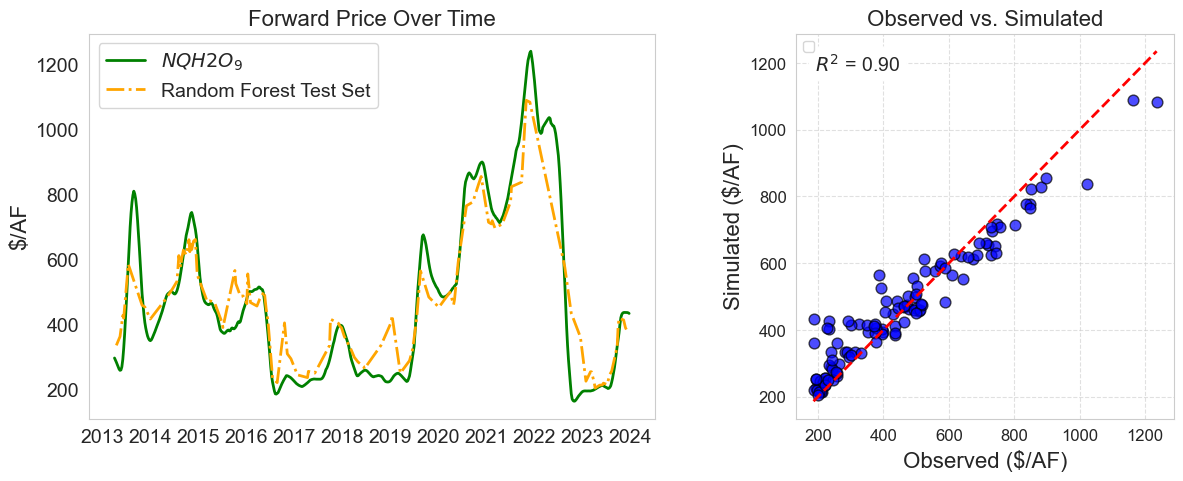

In [17]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2, width_ratios=[3, 2], wspace=0.3) 
ax1 = fig.add_subplot(gs[0])
# ax1.plot(merged_df['Date'], merged_df['NQH2O'], 
#     label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=2
# )
ax1.plot(merged_df['Date'], merged_df['9_Month_Forward_Avg'], 
    label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=2
)
ax1.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
    label='Random Forest Test Set', linestyle='-.', color='orange', linewidth=2
)
# ax1.plot(prediction_results['Date'], prediction_results['Predicted_RandomForest'], 
#     label=r'Predicted $NQH2O_{9}$', linestyle='-.', color='gold', linewidth=2
# )

ax1.set_ylabel('$/AF', fontsize=16)
ax1.set_title('Forward Price Over Time', fontsize=16)

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax1.legend(fontsize=14, loc='upper left')

ax1.grid(False)

# --------------------- Right Subplot: Scatter Plot ---------------------
ax2 = fig.add_subplot(gs[1])

scatter = ax2.scatter( y_test, y_pred_rf_test, color='blue', edgecolor='k', alpha=0.7, s=60)

max_val = max(max(y_test), max(y_pred_rf_test))
min_val = min(min(y_test), min(y_pred_rf_test))
ax2.plot(
    [min_val, max_val], [min_val, max_val], 
    'r--', linewidth=2, 
)

ax2.set_xlabel('Observed ($/AF)', fontsize=16)
ax2.set_ylabel('Simulated ($/AF)', fontsize=16)
ax2.set_title('Observed vs. Simulated', fontsize=16)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_rf_test)

# Annotate R² on the plot
ax2.text( 0.05, 0.95, f'$R^{{2}}$ = {r2:.2f}', 
    transform=ax2.transAxes, fontsize=14,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=1)
)

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

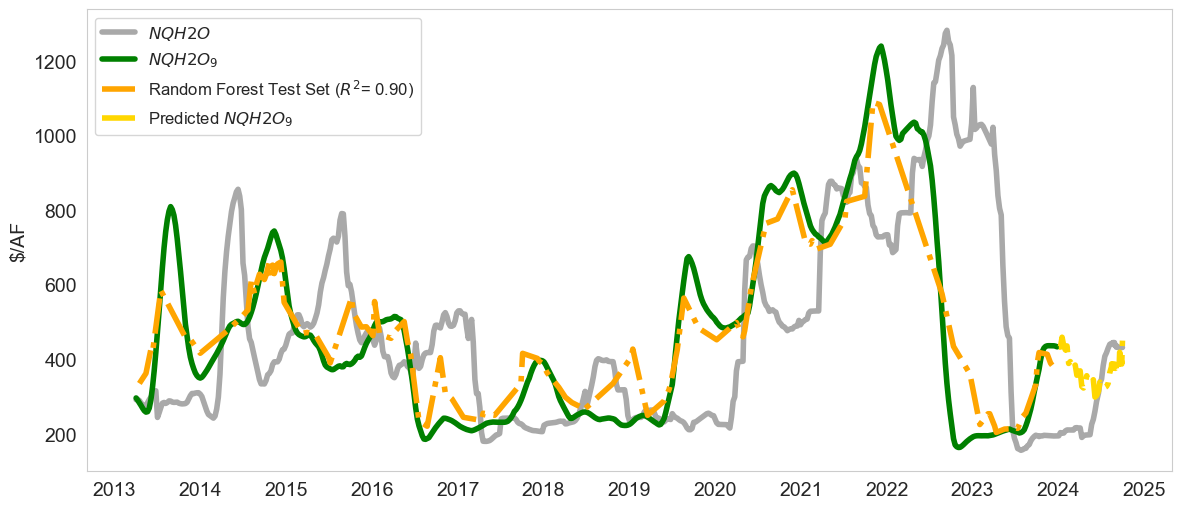

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
plt.plot(merged_df['Date'], merged_df['9_Month_Forward_Avg'], label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=4)

# Plotting predictions on the test set
plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
         label=f'Random Forest Test Set ($R^{{2}}$= {random_forest_test_r2:.2f})', 
         linestyle='-.', color='orange', linewidth=4)

# Plotting predictions on the last 9 months
plt.plot(prediction_results['Date'], prediction_results['Predicted_RandomForest'], 
         label=r'Predicted $NQH2O_{9}$', linestyle='-.', color='gold', linewidth=4)

plt.ylabel('$/AF', fontsize=14)
# plt.ylim(0, 1400)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(False)

plt.show()

In [19]:
test_results

,Date,Actual,NQH2O,Predicted_RandomForest
0,2013-04-17,283.420000,289.54,335.279526
1,2013-05-15,258.402222,273.74,362.347832
2,2013-06-05,291.501111,298.38,426.814448
3,2013-06-12,326.221111,305.22,418.771111
4,2013-07-17,588.670000,270.31,584.916015
...,...,...,...,...
108,2023-10-04,353.396667,195.11,392.824625
109,2023-10-11,373.298889,192.89,418.163019
110,2023-11-15,436.209231,195.48,413.483358
111,2023-11-29,436.340882,194.84,389.618360


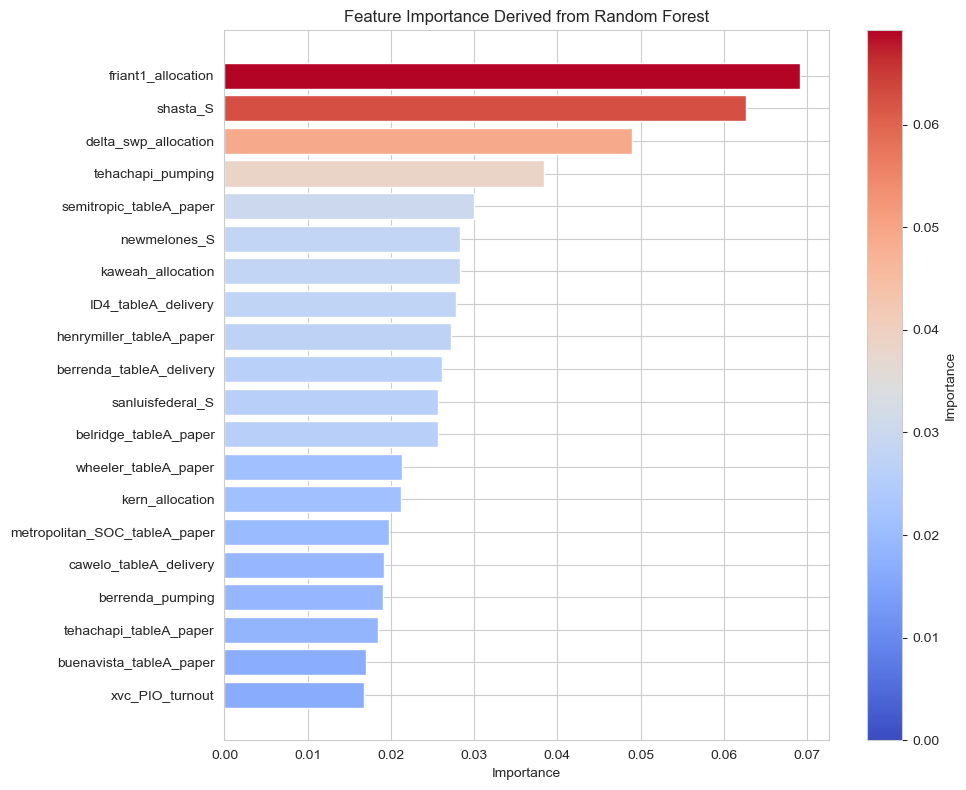

In [20]:
best_random_forest = random_forest_cv.best_estimator_
importances = best_random_forest.feature_importances_
feature_columns = joblib.load('feature_columns.pkl')
feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

# Sort the DataFrame by Importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances.head()

cmap = plt.cm.coolwarm  # Alternatives: 'plasma', 'coolwarm', 'magma', etc.
norm = mpl.colors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())
colors = cmap(norm(feature_importances['Importance']))

plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importances['Feature'].head(20), feature_importances['Importance'].head(20), color=colors)

# Add labels and title
plt.xlabel('Importance')
plt.title('Feature Importance Derived from Random Forest')

# Invert y-axis to have the highest importance at the top
plt.gca().invert_yaxis()

# Add a color bar to indicate the mapping of colors to importance values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)
cbar.set_label('Importance')

# Display the plot
plt.tight_layout()
plt.show()

## method selction

In [21]:


# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('elasticnet', ElasticNet(ElasticNet(max_iter=10000)))
# ])

# param_grid = {
#     'elasticnet__alpha': [1, 5, 10, 20,50.0, 100],
#     'elasticnet__l1_ratio': [0.1, 0.4,0.5]  #1 corresponds to pure L1 regularization (Lasso Regression) -->  sparse models
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')

# grid_search.fit(X_train_val, y_train_val)

# best_pipeline = grid_search.best_estimator_
# best_params = grid_search.best_params_
# print(f'Best params: {best_params}')


# y_pred = best_pipeline.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print(f'R² score on the test set with optimized ElasticNet: {r2:.2f}')

# elasticnet_coef = best_pipeline.named_steps['elasticnet'].coef_

# coefficients = pd.DataFrame({
#     'features': X.columns.tolist(),
#     'Coefficient': elasticnet_coef
# })

# coefficients['Rank'] = coefficients['Coefficient'].abs().rank(ascending=False)
# coefficients.sort_values(by='Rank')



In [22]:
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     # ('pca', PCA(n_components=5)),  # Adjust n_components based on your dataset
#     ('rf', RandomForestRegressor(random_state=42))
# ])

# param_grid = {
#     'rf__n_estimators': [100, 50, 200],  # Number of trees in the forest
#     'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
#     'rf__max_depth': [10, 20],  # Maximum depth of the tree
#     'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'rf__min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')
# grid_search.fit(X_train_val, y_train_val)

# best_pipeline = grid_search.best_estimator_
# best_params = grid_search.best_params_
# print(f'Best params: {best_params}')
# y_pred_test = best_pipeline.predict(X_test)

# r2_test = r2_score(y_test, y_pred_test)
# print(f'R² score on the test set with optimized RandomForestRegressor: {r2_test:.2f}')

# feature_importances = best_pipeline.named_steps['rf'].feature_importances_

# coefficients = pd.DataFrame({
#     'features': X.columns.tolist(),
#     'Importance': feature_importances
# })

# coefficients['Rank'] = coefficients['Importance'].rank(ascending=False)
# coefficients.sort_values(by='Rank')


# # Save the best pipeline
# joblib.dump(best_pipeline, 'random_forest_pipeline_with_pca.pkl')

In [23]:
# # lasso_pipeline = joblib.load('lasso_pipeline_top_20.pkl')
# # top_features = joblib.load('top_features.pkl')
# # elasticnet_pipeline = joblib.load('elasticnet_pipeline_optimized.pkl')
# random_forest_pipeline_with_pca = joblib.load('random_forest_pipeline_with_pca.pkl')
# # pca = joblib.load('pca_model.pkl')

# output_folder = 'results/'

# plt.figure(figsize=(15, 10))
# all_predictions = []
# all_indices = []
# for scenario_number in range(1, 101):
#     scenario_folder = os.path.join(output_folder, str(scenario_number))
#     output_file = os.path.join(scenario_folder, 'results.hdf5')
#     hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

#     # Calculate rolling mean
#     window_size = '180D'
#     X = hydro_data.rolling(window=window_size, center=False).mean()
#     X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

#     # Ensure feature columns match
#     # X_top_20 = ensure_columns_match(X, top_features)
#     # predicted_index_price = lasso_pipeline.predict(X_top_20)
#     X_matched = ensure_columns_match(X, feature_columns)
#     # X_pca = pca.transform(X_matched)
#     predicted_index_price = random_forest_pipeline_with_pca.predict(X_matched)
    
#     all_predictions.append(predicted_index_price)
#     all_indices.append(X.index)
    

In [24]:
# plt.figure(figsize=(14, 6))
# for i in range(len(all_predictions)):
#     plt.plot(all_indices[i], all_predictions[i], label=f'Scenario {i+1}')

# # Finalize the main plot
# plt.xlabel('Date')
# plt.ylabel('Index Price')
# plt.grid(False)
# # plt.ylim(-2000, 1000)
# plt.title('Predicted Index Prices Over Time for Various Scenarios')
# plt.show()

# Predict the index itself based on synthetic traces

In [25]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df['dowy'] = merged_df['Date'].apply(calculate_dowy)  
merged_df.fillna(merged_df.mean(), inplace=True)
# merged_df['y_10d_avg'] = merged_df['NQH2O'].rolling(window=10, min_periods=1).mean()  #add 3 month average of 9 month forward average to capture trend
# merged_df
X = merged_df.drop(columns=['Date', 'NQH2O', '9_Month_Forward_Avg'])
y = merged_df['NQH2O']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)



# suffixes = ('_S',  '_allocation', 'dowy', '_SNPK', '_demand','_delivery','_pumping','_Q','_R') #' '_exchanged_GW',
suffixes = ('dowy','_S', '_R', 'flood_spill','_delivery', '_allocation', '_paper',  '_SNPK', '_pumping', '_demand','_downstream', '_turnout',) # '_Q', '_R',
# suffixes = ('dowy','_S', '_R', '_delivery', '_allocation', '_SNPK', '_pumping', '_demand', '_downstream', '_turnout', '_flood','flood_spill','flood_deliveries','_paper','_exchanged_GW',) #'_exchanged_GW','_carryover', '_Q', '_paper',  
filtered_columns = [col for col in X.columns if col.endswith(suffixes)]
X = X[filtered_columns]

exclude_columns = ['dowy', ]
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if column not in exclude_columns and any(upper[column] > 0.8)]   #column != 'dowy' and
print(f"Number of columns to drop: {len(to_drop)}")
X = X.drop(columns=to_drop)

X

Duplicate columns found: ['socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_dynamic_recovery_cap', 'socal_tableA_delivery', 'socal_irr_demand', 'socal_tot_demand', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_dynamic_recharge_cap', 'socal_tableA_recharged', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_pumping', 'socal_tableA_turnback', 'socal_recover_banked', 'socal_tableA_carryover', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_recharge_cap', 'centralcoast_friant1_dynamic_recharge_cap', 'centralcoast_friant2_dynamic_recharge_cap', 'centralcoast_kaweah_

,shasta_S,shasta_R,shasta_SNPK,shasta_downstream,oroville_R,oroville_downstream,yuba_S,yuba_R,newmelones_S,newmelones_R,...,knc_PIO_turnout,knc_BVA_turnout,cwy_POSO_turnout,cwy_NKB_turnout,lrd_CWO_turnout,knr_PIO_turnout,kwr_TUL_turnout,kwr_KWD_turnout,kgr_CNS_turnout,dowy
0,3881.024140,6.018645,36.90,5.841322,7.754267,1.241256,826.200411,6.118165,1628.079790,5.186380,...,4.221351e-05,0.000000,0.0,0.000000,1.665335e-17,0.0,3.660392e-02,1.000946e-01,0.549352,185
1,3972.574025,4.609983,36.90,10.218446,11.308196,-0.000397,843.928575,5.160058,1613.660749,3.041256,...,1.784800e-03,0.000000,0.0,0.000000,1.665335e-17,0.0,2.220446e-17,3.552714e-16,0.622482,192
2,4052.274653,5.683041,36.90,5.309752,9.786425,-0.279669,861.342013,3.644046,1602.598018,3.932271,...,0.000000e+00,0.000000,0.0,0.000000,1.665335e-17,0.0,2.220446e-17,3.552714e-16,0.411902,199
3,4062.978144,16.250267,36.90,-6.141620,3.675794,-2.017983,877.170684,2.283051,1589.028974,3.174307,...,0.000000e+00,0.000000,0.0,0.000000,1.665335e-17,0.0,2.220446e-17,3.552714e-16,0.000000,206
4,3986.398923,19.927086,36.90,-9.596430,9.868634,-7.225388,897.507358,1.793464,1577.453040,3.048674,...,0.000000e+00,0.000000,0.0,0.000000,1.490967e-05,0.0,2.235628e-03,1.117990e-03,0.002258,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2962.991615,11.251208,67.43,2.908165,12.647210,-1.816463,786.381209,3.664958,1890.868772,1.649058,...,1.242775e-02,0.137207,0.0,0.057408,4.807928e-02,0.0,1.280822e-01,1.080636e-01,0.316164,360
622,2956.888308,12.053117,67.43,2.852628,14.397481,-4.462017,783.561504,3.818061,1890.234061,1.752595,...,6.244833e-04,0.137207,0.0,0.057408,5.337901e-02,0.0,1.220576e-01,1.076612e-01,0.305195,361
623,2949.499124,12.005049,67.43,2.822479,15.045307,-5.159405,780.557253,3.796002,1889.453367,1.763306,...,6.244833e-04,0.129257,0.0,0.065631,5.653452e-02,0.0,1.121659e-01,1.083534e-01,0.294226,362
624,2942.558670,11.393819,67.43,2.683636,13.728581,-2.799074,777.548106,3.631706,1888.676243,1.549884,...,6.244833e-04,0.121306,0.0,0.073304,5.849455e-02,0.0,1.016697e-01,1.098087e-01,0.283257,363


In [26]:
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns2.pkl') # save feature columns for prediction later

X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']
X.shape

(626, 110)

In [27]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=5)),  
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 50, 200],  # Number of trees in the forest
    'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'rf__max_depth': [10, 20],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train_val, y_train_val)

best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best params: {best_params}')
y_pred_test = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print(f'R² score on the test set with optimized RandomForestRegressor: {r2_test:.3f}')

feature_importances = best_pipeline.named_steps['rf'].feature_importances_

coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})

coefficients['Rank'] = coefficients['Importance'].rank(ascending=False)
coefficients.sort_values(by='Rank')

# Save the best pipeline
joblib.dump(best_pipeline, 'NQH2O_random_forest_pipeline_with_pca.pkl')

Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
R² score on the test set with optimized RandomForestRegressor: 0.920


['NQH2O_random_forest_pipeline_with_pca.pkl']

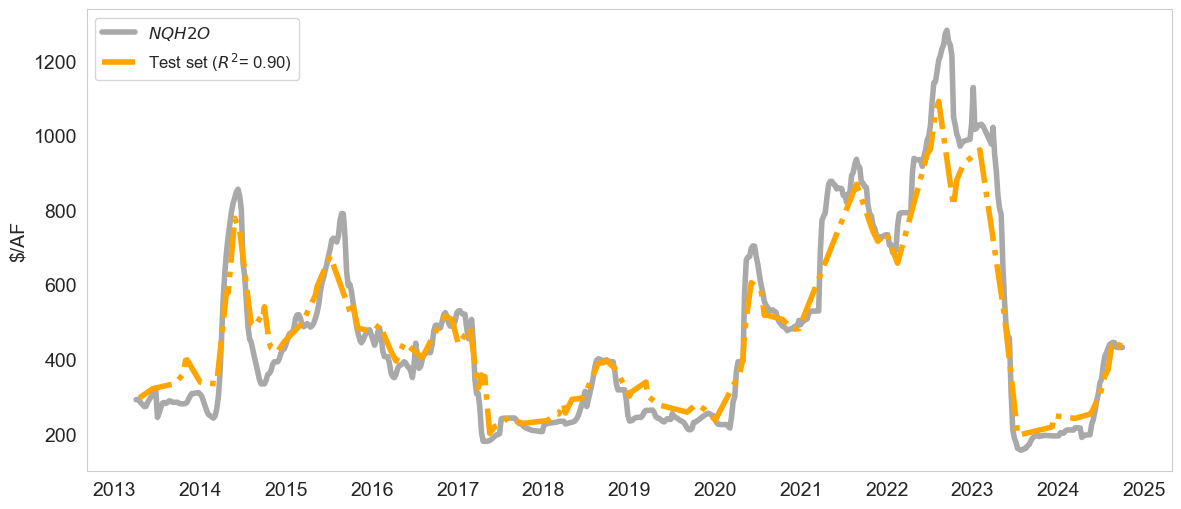

In [28]:
test_results = pd.DataFrame({
    'Date': test_date, 
    'Actual': y_test,
    'NQH2O': test_nqh2o,
    'Predicted_RandomForest': y_pred_test
})

test_results = test_results.sort_values(by='Date').reset_index(drop=True)

plt.figure(figsize=(14, 6))

plt.plot(merged_df['Date'], merged_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
# plt.plot(merged_df['Date'], merged_df['9_Month_Forward_Avg'], label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=4)

# Plotting predictions on the test set
plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
         label=f'Test set ($R^{{2}}$= {random_forest_test_r2:.2f})', 
         linestyle='-.', color='orange', linewidth=4)


plt.ylabel('$/AF', fontsize=14)
# plt.ylim(0, 1400)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(False)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


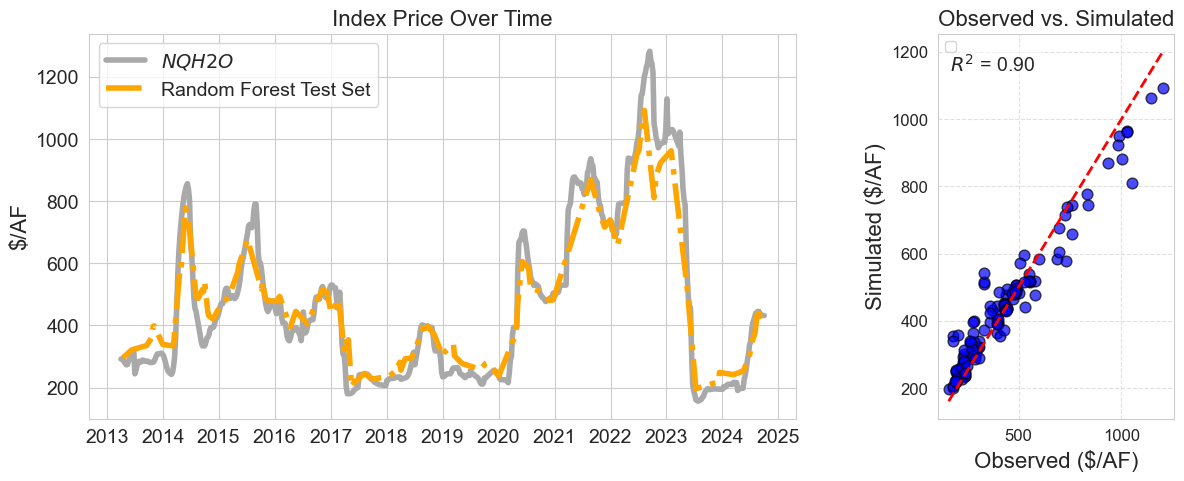

In [29]:
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3) 
ax1 = fig.add_subplot(gs[0])
ax1.plot(merged_df['Date'], merged_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
ax1.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
         label='Random Forest Test Set', 
         linestyle='-.', color='orange', linewidth=4)
ax1.set_ylabel('$/AF', fontsize=16)
ax1.set_title('Index Price Over Time', fontsize=16)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax1.legend(fontsize=14, loc='upper left')

ax2 = fig.add_subplot(gs[1])

scatter = ax2.scatter( y_test, y_pred_test, 
    color='blue', edgecolor='k', alpha=0.7, s=60
)

max_val = max(max(y_test), max(y_pred_test))
min_val = min(min(y_test), min(y_pred_test))
ax2.plot(
    [min_val, max_val], [min_val, max_val], 
    'r--', linewidth=2, 
)

ax2.set_xlabel('Observed ($/AF)', fontsize=16)
ax2.set_ylabel('Simulated ($/AF)', fontsize=16)
ax2.set_title('Observed vs. Simulated', fontsize=16)


# Annotate R² on the plot
ax2.text( 0.05, 0.95, f'$R^{{2}}$ = {r2:.2f}', 
    transform=ax2.transAxes, fontsize=14,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

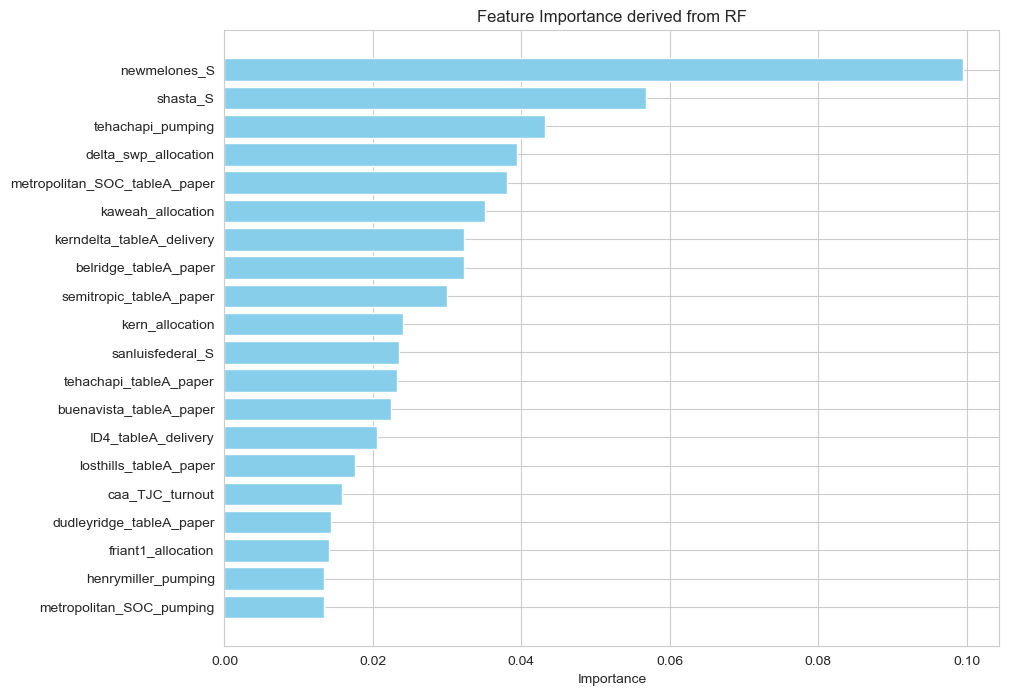

In [30]:
coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})
coefficients = coefficients.sort_values(by='Importance', ascending=False)
coefficients['Rank'] = range(1, len(coefficients) + 1)
plt.figure(figsize=(10, 8))
plt.barh(coefficients.head(20)['features'], coefficients.head(20)['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance derived from RF')
plt.gca().invert_yaxis()  # To have the highest rank at the top
plt.show()

In [31]:
print(coefficients.head(6)[['features']])
# feature_importances

                         features
8                    newmelones_S
0                        shasta_S
51              tehachapi_pumping
21           delta_swp_allocation
68  metropolitan_SOC_tableA_paper
25              kaweah_allocation


In [33]:
# top_10_features = coefficients.head(6)['features'].tolist()
# n_features = len(top_10_features)
# n_cols = 3  # Number of columns in the subplot grid
# n_rows = (n_features + n_cols - 1) // n_cols  # Calculate the number of rows needed

# fig, axes = plt.subplots(6, 1, figsize=(3, 1.5 * 6))  # Adjust figsize as needed
# plt.style.use('default')
# axes = axes.flatten()

# for i, feature in enumerate(top_10_features):
#     ax = axes[i]
#     PartialDependenceDisplay.from_estimator(
#         best_pipeline,    # trained estimator (e.g., RandomForestRegressor)
#         X,                # Feature dataset used for training
#         [feature],        # Current feature to plot
#         ax=ax,       # Current subplot axis
#         # grid_resolution=50,  # Number of points on the grid for each feature
#         kind='average'    # Type of PDP ('average' or 'individual')
#     )
#     ax.grid(False)
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     lines = ax.get_lines()
#     if lines:
#         # Set the label for the first line
#         lines[0].set_label(feature)
#         # Add the legend to the plot
#         ax.legend(loc='best')

# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])
# plt.tight_layout()
# plt.grid(False)
# plt.show()

In [34]:
random_forest_pipeline_with_pca = joblib.load('NQH2O_random_forest_pipeline_with_pca.pkl')
# elasticnet_pipeline_optimized = joblib.load('elasticnet_pipeline_optimized.pkl')
# pca = joblib.load('pca_model.pkl')

output_folder = 'results/'

plt.figure(figsize=(15, 10))
all_predictions = []
all_indices = []
# rolling_window_size = 10

for scenario_number in range(1, 101):
    scenario_folder = os.path.join(output_folder, str(scenario_number))
    output_file = os.path.join(scenario_folder, 'results.hdf5')
    hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

    # Calculate rolling mean
    window_size = '5D'
    X = hydro_data.rolling(window=window_size, center=False).mean()
    X.index.name = 'Date'
    X = X.reset_index()
    X['dowy'] = X['Date'].apply(calculate_dowy) 
    X.set_index('Date', inplace=True)
    X_matched = ensure_columns_match(X, feature_columns)
    
    # Predict y using the model
    predicted_y = random_forest_pipeline_with_pca.predict(X_matched)
    
    # Append the prediction to the lists
    # predictions.append(predicted_y)
    # predicted_y_list.append(predicted_y)

    all_predictions.append(predicted_y)
    all_indices.append(X.index)

<Figure size 1500x1000 with 0 Axes>

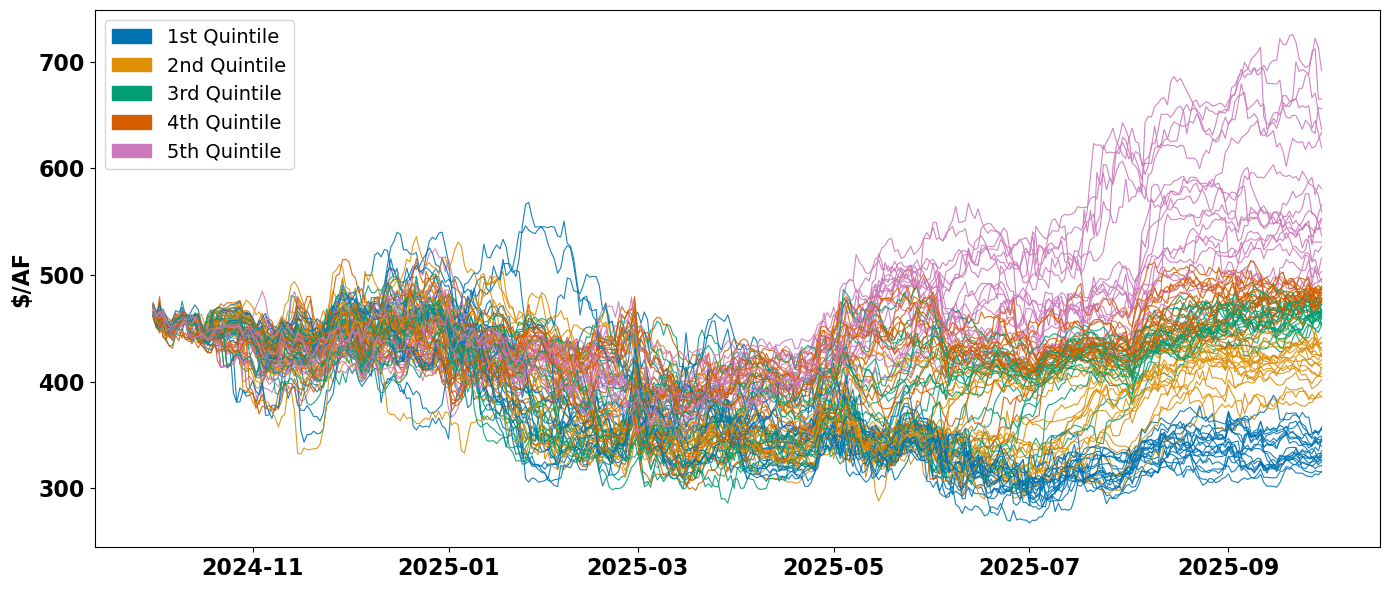

In [35]:
predictions_array = np.array(all_predictions).T  # Shape: (time points, scenarios)
reference_index = all_indices[0]
predictions_df = pd.DataFrame(predictions_array, index=reference_index, columns=[f'Scenario {i}' for i in range(1, 101)])
predictions_df = predictions_df.iloc[0:365]
final_values = predictions_df.iloc[-1]  # Get the last value for each scenario

quintiles = pd.qcut(final_values, 5, labels=False)  # Labels 0 to 4

palette = sns.color_palette("colorblind", 5)  # 5 distinct colors

color_mapping = quintiles.map(lambda x: palette[x])

plt.figure(figsize=(14, 6))

scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]
for column in scenarios_to_plot:
    plt.plot(predictions_df.index, 
        predictions_df[column], 
        color=color_mapping[column], 
        linewidth=0.8, 
        alpha=0.9
    )

import matplotlib.patches as mpatches

quintile_labels = ['1st Quintile', '2nd Quintile', '3rd Quintile', '4th Quintile', '5th Quintile']
patches = [mpatches.Patch(color=palette[i], label=quintile_labels[i]) for i in range(5)]
plt.legend(handles=patches, fontsize=14, title_fontsize=14, loc='upper left')

# Optional: Format the x-axis if dealing with dates
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Additional Plot Customizations
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.ylabel('$/AF', fontsize=16, fontweight='bold')
# plt.title('Predicted Prices Across 100 Scenarios by Quintile', fontsize=18, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()


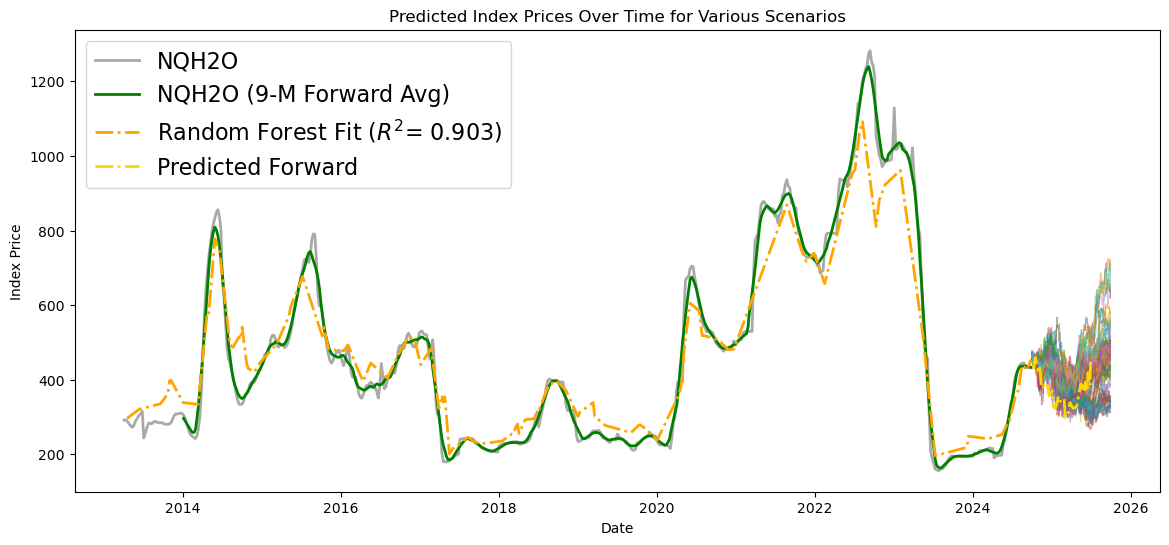

In [36]:
plt.figure(figsize=(14, 6))
scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]
for column in scenarios_to_plot:
    plt.plot(predictions_df.index, predictions_df[column],  linewidth=0.8, alpha=0.5)

merged_shifted_dates = merged_df['Date'] + pd.DateOffset(months=9)
# test_shifted_dates = test_results['Date'] + pd.DateOffset(months=9)
pred_shifted_dates = prediction_results['Date'] + pd.DateOffset(months=9)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(merged_shifted_dates, merged_df['9_Month_Forward_Avg'], label='NQH2O (9-M Forward Avg)', linestyle='-', color='green', linewidth=2)
plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
         label=f'Random Forest Fit ($R^{{2}}$= {random_forest_test_r2:.3f})', 
         linestyle='-.', color='orange', linewidth=2)
plt.plot(pred_shifted_dates, prediction_results['Predicted_RandomForest'], 
         label='Predicted Forward', linestyle='-.', color='gold', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.legend(fontsize=16)
plt.grid(False)
# plt.ylim(250, 750)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
plt.show()

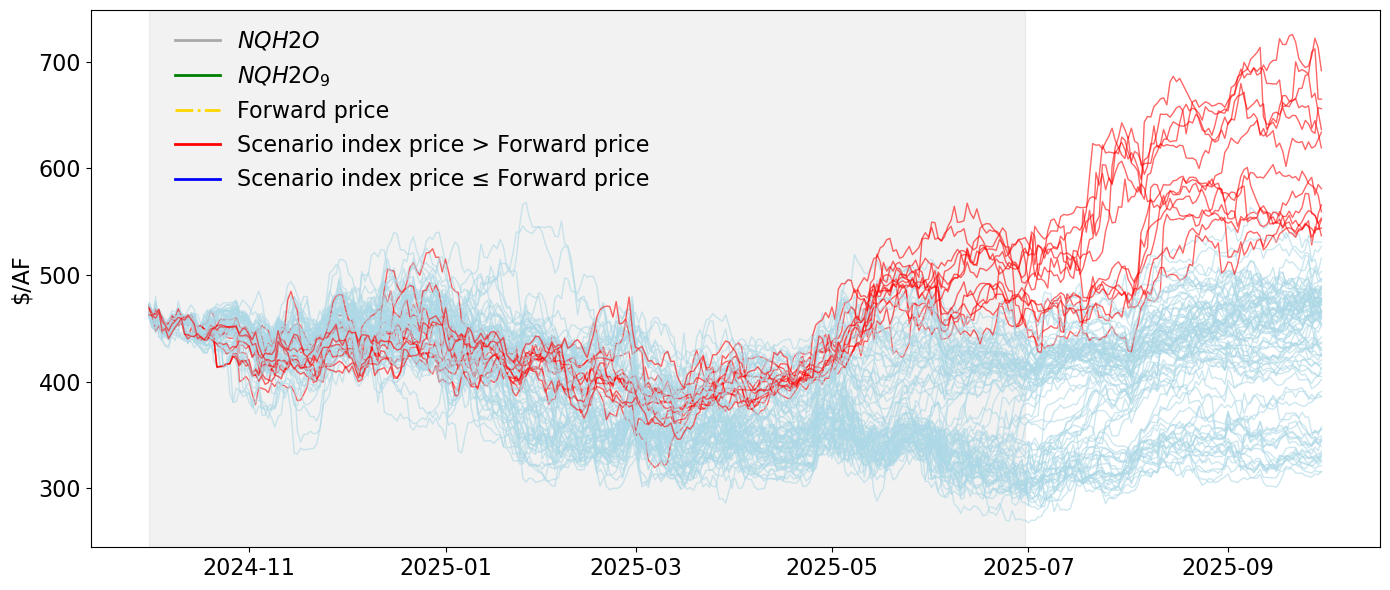

In [64]:
from matplotlib.lines import Line2D

# --- Step 1: Data Preparation ---
plt.figure(figsize=(14, 6))
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
test_results['Date'] = pd.to_datetime(test_results['Date'])
prediction_results['Date'] = pd.to_datetime(prediction_results['Date'])


merged_df['Date_shift']  = merged_df['Date'] + pd.DateOffset(months=9)
test_results['Date_shift'] = test_results['Date'] + pd.DateOffset(months=9)
prediction_results['Date_shift'] = prediction_results['Date'] + pd.DateOffset(months=9)


rf_predictions = prediction_results.set_index('Date_shift')['Predicted_RandomForest']

last_rf_date = pd.Timestamp(rf_predictions.index[-1])

higher_scenarios = []
lower_scenarios = []

scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]

colors = []

for scenario in scenarios_to_plot:

    scenario_pred = predictions_df[scenario]
    
    if last_rf_date in scenario_pred.index:
        scenario_last_pred = scenario_pred.loc[last_rf_date]
    else:
        scenario_last_pred = scenario_pred.loc[:last_rf_date].iloc[-1]

    rf_last_pred = rf_predictions.loc[last_rf_date]

    if scenario_last_pred > rf_last_pred:
        color = 'red'   # Scenario's last prediction is higher than RF's
        higher_scenarios.append(scenario)
    else:
        color = 'lightblue'  # Scenario's last prediction is not higher than RF's
        lower_scenarios.append(scenario)
    
    # Append color to list (optional)
    colors.append(color)
    
    # Plot the scenario with the assigned color
    plt.plot(predictions_df.index, scenario_pred, color=color, linewidth=1, alpha=0.6 )

# plt.plot( merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-',  color='darkgrey',  linewidth=4)

# plt.plot(  merged_df['Date_shift'],  merged_df['9_Month_Forward_Avg'], label='NQH2O (9-M Forward Avg)', linestyle='-', color='green', linewidth=4)

# plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], label=f'Test set ($R^{{2}}$= {random_forest_test_r2:.2f})', linestyle='-.',  color='orange',  linewidth=4)

# plt.plot(prediction_results['Date_shift'], prediction_results['Predicted_RandomForest'], label='Predicted index price', linestyle='-.', color='gold', linewidth=4)

# plt.title('Predicted Index Prices Over Time for Various Scenarios', fontsize=18, fontweight='bold')
# plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('$/AF', fontsize=16)
start_date = pd.to_datetime('2024-10-01')
end_date = pd.to_datetime('2025-06-30')

plt.axvspan(start_date, end_date, color='grey', alpha=0.1, label='Period of Interest')
custom_lines = [
        Line2D([0], [0], color='darkgrey', lw=2, label=r'$NQH2O$'),
    Line2D([0], [0], color='green', lw=2, label=r'$NQH2O_{9}$'),
        # Line2D([0], [0], color='orange', lw=2, linestyle='-.', label=f'Random Forest test set ($R^{{2}}$= {random_forest_test_r2:.2f})'),
    Line2D([0], [0], color='gold', lw=2, linestyle='-.', label='Forward price'),
    Line2D([0], [0], color='red', lw=2, label='Scenario index price > Forward price'),
    Line2D([0], [0], color='blue', lw=2, label='Scenario index price ≤ Forward price'),
]

# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(handles=custom_lines, loc='upper left', fontsize=16, framealpha=0, bbox_to_anchor=(0.05, 1),)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid(False)

plt.show()


In [39]:
print("Scenarios with last prediction higher than RF's last prediction:")
for scenario in higher_scenarios:
    print(scenario)

# Option 2: Print scenario numbers only
higher_scenario_numbers = [int(scenario.split(' ')[1]) for scenario in higher_scenarios]
print("\nScenario numbers with last prediction higher than RF's last prediction:")
print(higher_scenario_numbers)

Scenarios with last prediction higher than RF's last prediction:
Scenario 5
Scenario 7
Scenario 38
Scenario 46
Scenario 49
Scenario 61
Scenario 62
Scenario 69
Scenario 79
Scenario 80
Scenario 82
Scenario 99
Scenario 100

Scenario numbers with last prediction higher than RF's last prediction:
[5, 7, 38, 46, 49, 61, 62, 69, 79, 80, 82, 99, 100]


In [40]:
print(last_rf_date)
print(rf_last_pred)

2025-06-30 00:00:00
450.1014916825397


In [41]:
# selected_columns = ['Scenario 8', 'Scenario 9', 'Scenario 15', 'Scenario 16', 'Scenario 33', 'Scenario 56','Scenario 79','Scenario 94']

selected_predictions = predictions_df[higher_scenarios]
last_rf_date = pd.Timestamp(rf_predictions.index[-1])

rf_last_pred = rf_predictions.loc[last_rf_date]

scenario_last_pred = selected_predictions.loc[last_rf_date]

payouts = scenario_last_pred - rf_last_pred
payouts_df = payouts.reset_index()
payouts_df.columns = ['Scenario', 'Payout']


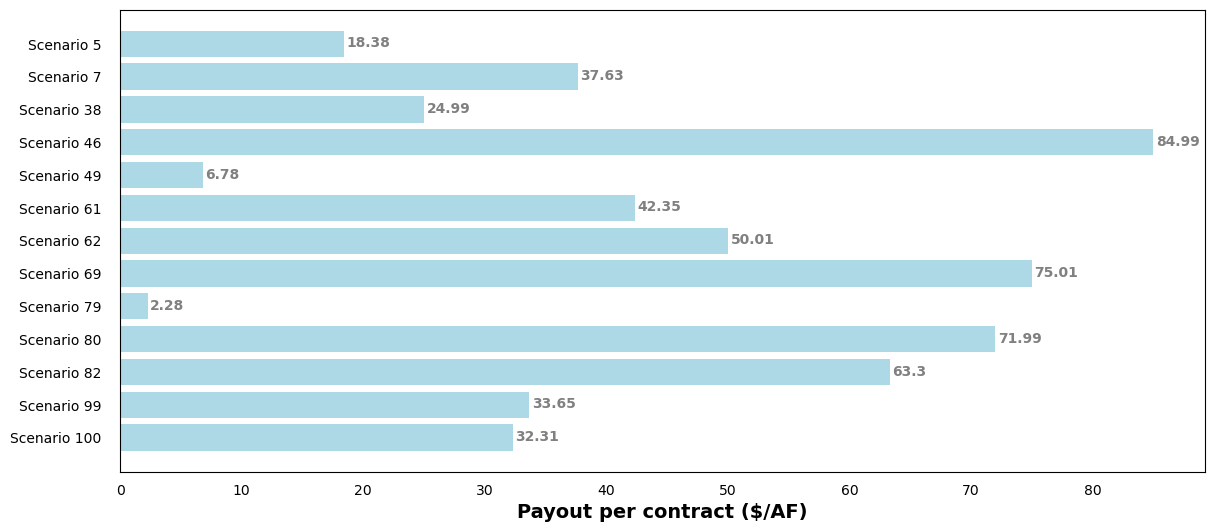

In [53]:
fig, ax = plt.subplots(figsize =(14, 6))
ax.barh(payouts_df['Scenario'], payouts_df['Payout'], color ='lightblue')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(True)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# ax.grid(visible = False, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.xlabel('Payout per contract ($/AF)', fontsize=14, fontweight='bold')
# plt.xticks(False)
plt.show()

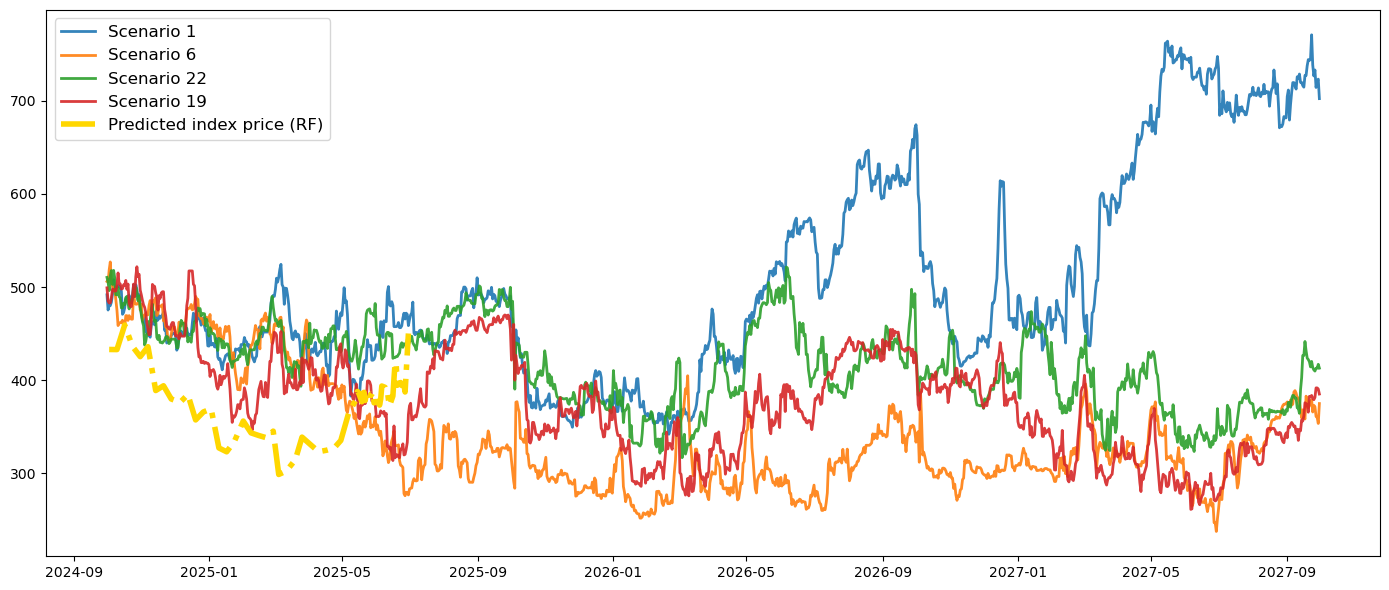

In [2092]:
plt.figure(figsize=(14, 6))
scenarios_to_plot = [f'Scenario {i}' for i in [1,6,22,19]]
for column in scenarios_to_plot:
    plt.plot(X.index, predictions_df[column], label=column, linewidth=2, alpha=0.9)
plt.plot(pred_shifted_dates, prediction_results['Predicted_RandomForest'], label='Predicted index price (RF)', linestyle='-.', color='gold', linewidth=4)
plt.tight_layout()
plt.grid(False)
plt.legend(fontsize=12)
plt.show()

<Figure size 1200x500 with 0 Axes>

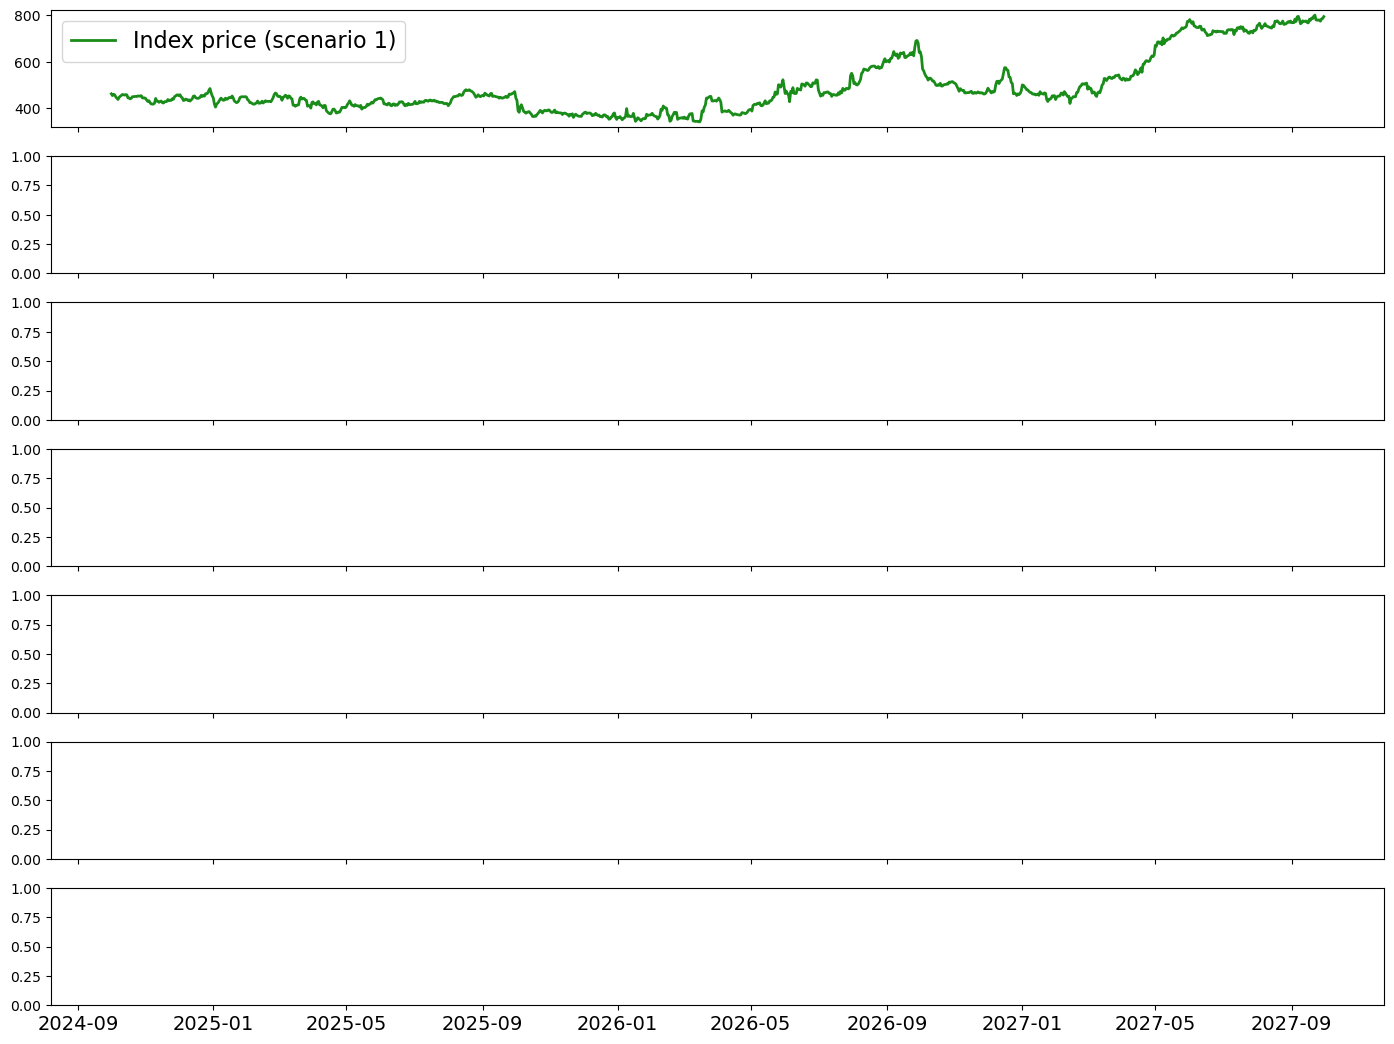

In [56]:
plt.figure(figsize=(12, 5))
output_file = os.path.join('results', str(1), 'results.hdf5')
datDaily_15 = get_results_sensitivity_number_outside_model(output_file, '')
columns_to_plot = [
'newmelones_S',
                      'shasta_S',
              'tehachapi_pumping',
           'delta_swp_allocation',
  'metropolitan_SOC_tableA_paper',
              'kaweah_allocation',
]

num_plots = len(columns_to_plot) + 1

# Create subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(14, 1.5 * num_plots), sharex=True)
if num_plots == 1:
    axes = [axes]
axes[0].plot(predictions_df.index, predictions_df['Scenario 1'], label='Index price (scenario 1)', color='g', linewidth=2, alpha=0.9)
axes[0].legend(loc='upper left', fontsize=16)
axes[0].xaxis.set_tick_params(labelsize=20)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)

# for ax, column in zip(axes[1:], columns_to_plot):
#     ax.plot(datDaily_15.index, datDaily_15[column], label=column, color='darkgrey')
#     # ax.set_ylabel(column)
#     ax.legend(loc='lower left', fontsize=16)
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(False)

plt.tight_layout()
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.show()

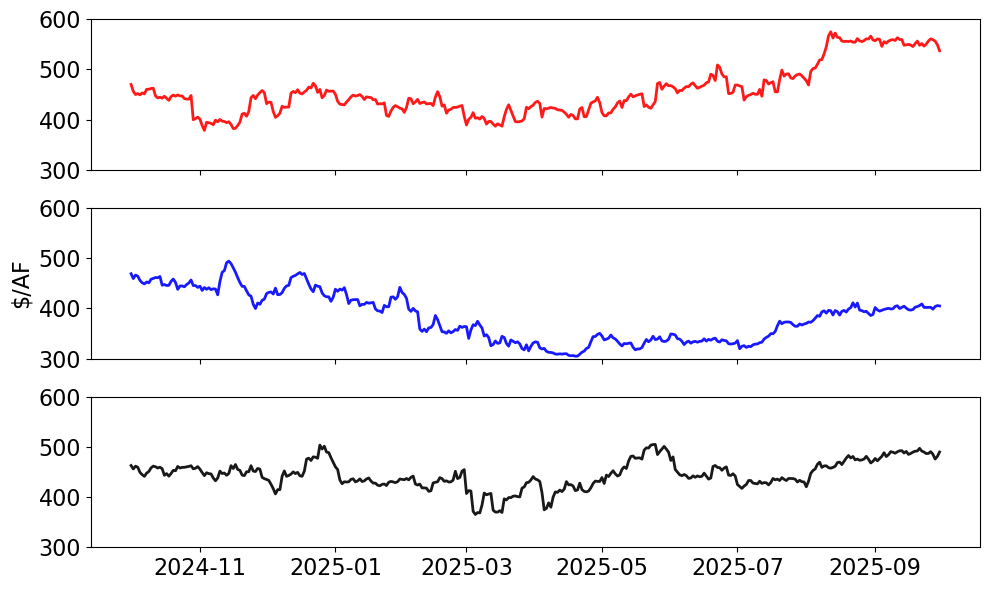

In [45]:
import matplotlib.pyplot as plt

scenarios = ['Scenario 5', 'Scenario 2', 'Scenario 4']
colors = ['r', 'b', 'black']

num_plots = len(scenarios)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 2 * num_plots), sharex=True)

if num_plots == 1:
    axes = [axes]

for ax, scenario, color in zip(axes, scenarios, colors):
    ax.plot(predictions_df.index,  predictions_df[scenario],  label=f'Index Price ({scenario})',  color=color, linewidth=2, alpha=0.9 )
    # ax.legend(fontsize=12, loc='upper left')
    ax.set_ylim(300, 600)
    ax.set_yticks([300, 400, 500, 600])
    # ax.tick_params(axis='y', size=16)
    # ax.set_ylabel('$/AF', fontsize=16) 
    ax.tick_params(axis='y', labelsize=16)
    # ax.set_ylabel('Index Price', fontsize=12)
    # ax.set_title(f'Water Index Prediction - {scenario}', fontsize=14)

axes[-2].set_ylabel('$/AF', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylabel('$AF', fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
from scipy.stats import zscore
all_predictions_array = np.array(all_predictions)
z_scores = np.abs(zscore(all_predictions_array, axis=0, nan_policy='omit'))

# Filter out extreme values where Z-score > threshold (here: 23 standard deviations)
threshold = 3
filtered_indices = np.where((z_scores < threshold).all(axis=1))[0]
filtered_predictions = all_predictions_array[filtered_indices]
average_prediction = np.mean(filtered_predictions, axis=0)

plt.figure(figsize=(14, 6))

for scenario_index in filtered_indices:
    plt.plot(X.index, all_predictions[scenario_index], label=f'Scenario {scenario_index + 1}', alpha=0.2)

plt.plot(X.index, average_prediction, label='Average Prediction', color='red', linewidth=2)

merged_shifted_dates = merged_df['Date'] + pd.DateOffset(months=9)
test_shifted_dates = test_results['Date'] + pd.DateOffset(months=9)
pred_shifted_dates = prediction_results['Date'] + pd.DateOffset(months=9)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(merged_shifted_dates, merged_df['9_Month_Forward_Avg'], label='NQH2O (9-M Forward Avg)', linestyle='-', color='green', linewidth=2)
plt.plot(test_shifted_dates, test_results['Predicted_RandomForest'], 
         label=f'Random Forest Fit ($R^{{2}}$= {random_forest_test_r2:.3f})', 
         linestyle='-.', color='orange', linewidth=2)
plt.plot(pred_shifted_dates, prediction_results['Predicted_RandomForest'], 
         label='Predicted RF (Future)', linestyle='-.', color='gold', linewidth=2)
# plt.plot(test_results['date'], test_results['predicted_rf'], label=f'Random Forest Fit ($R^{{2}}$= {r2_test:.2f})', linestyle=':', color='orange', linewidth=2)
# Finalize the main plot
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.grid(False)
# plt.ylim(-2000, 1000)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
plt.show()

NameError: name 'all_predictions' is not defined

In [2095]:
average_prediction

array([498.49837374, 491.79989764, 492.17878359, ..., 439.99817431,
       439.02308416, 438.27495146])